In [11]:
%matplotlib inline
from utils import read, createGraph, readExtraInfo, readGenre, readBirthdays, getCharacterAges
from glob import iglob as glob
from os.path import exists, basename
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
import numpy as np
import scipy as sp
import warnings
import networkx as nx
import logging
from funcy import walk_values
from scipy import stats
import itertools
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison

plt.rcParams["figure.figsize"] = (10, 8)

In [2]:
logging.basicConfig(format = "%(asctime)-15s %(message)s", level = logging.DEBUG)

In [3]:
th = 2
data_dir = "../data/utterances_with_charnames/*"
info_dir = "../data/charandmovie_info/"
birthdays_f = "../data/age/actor_birthdays.txt"

## Read all scripts

In [4]:
birthdays = readBirthdays(birthdays_f)

In [5]:
data = {}
for script in glob(data_dir):
    
    _, char_list, adj = read(script, threshold = th)

    extra_info = info_dir + basename(script)
    if exists(extra_info):
        genders, races, namesids, movieyear = readExtraInfo(extra_info)
        genres = readGenre(extra_info)
    else:
#         logging.warning("Info for {} not found".format(basename(script)))
#         gens = defaultdict(lambda: 'unknown')
#         races = defaultdict(lambda: 'unknown')  
        continue
        
    races = walk_values(lambda x: x.split(",")[0], races)
    ages = getCharacterAges(char_list, namesids, movieyear, birthdays)
        
        
    G = createGraph(char_list,
                    adj,
                    genders = genders,
                    races = races,
                    ages = ages)

    

    key = basename(script)

    data[key] = {}
    data[key]['graph'] = G
    data[key]['chars'] = char_list
    data[key]['genres'] = genres
    data[key]['ages'] = ages
    data[key]['races'] = races
    data[key]['year'] = movieyear
    

In [6]:
data['american_beauty.txt'];

In [7]:
np.sum([nx.number_of_nodes(d['graph']) for d in data.values()])

15133

In [8]:
types = Counter([y for x in [d['genres'] for script, d in data.items()] for y in x])
print(types)
types = list(types.keys())

Counter({'Drama': 559, 'Thriller': 368, 'Comedy': 287, 'Action': 252, 'Crime': 242, 'Romance': 194, 'Adventure': 170, 'Sci-Fi': 156, 'Mystery': 145, 'Horror': 116, 'Fantasy': 115, 'Biography': 70, 'Family': 49, 'War': 34, 'History': 34, 'Animation': 32, 'Sport': 32, 'Music': 22, 'Musical': 19, 'Western': 17, 'Short': 5, 'Film-Noir': 5})


In [9]:
races = Counter([y for x in [list(d['races'].values()) for d in data.values()] for y in x])
print(races)
races = list(races.keys())

Counter({'unknown': 7893, 'caucasian': 6895, 'african': 717, 'latino': 233, 'other': 194, 'eastasian': 97, 'nativeamerican': 68, 'asianindian': 66, 'pacificislander': 18, 'others': 2})


In [12]:
xkcd_colors = sns.xkcd_palette(["grass green", "sand", "blue", "light red", "cerulean",
                                "red", "light blue", "teal", "orange", "light green",
                                "magenta", "yellow", "sky blue", "grey", "cobalt",
                                "grass", "algae green", "coral", "cerise", "steel",
                                "hot purple", "mango", "pale lime", "rouge"])
colors = itertools.cycle(xkcd_colors)

# Pre-check
In [GENDER BIAS WITHOUT BORDERS](http://seejane.org/wp-content/uploads/gender-bias-without-borders-executive-summary.pdf), there is a ratio of 2.25 men for every women on screen (women = $30.9$%). Lets check our numbers.

In [ ]:
total, males, females = 0, 0, 0
for _, d in data.items():
    G = d['graph']
    
    for i in G.nodes():
        if G.node[i]['gender'] == 'male':
            males += 1
        elif G.node[i]['gender'] == 'female':
            females += 1
        
        total += 1
        
print("total: {}".format(total))
print("males: {:.2f}%".format(float(males) / total))
print("females: {:.2f}%".format(float(females) / total))


What if we drop unknown?... shouldn't matter right?

In [ ]:
print("males: {:.2f}%".format(float(males) / (males + females)))
print("females: {:.2f}%".format(float(females) / (males + females)))

# Graph analysis


# Betweeness Centrality

#### Average centrality

In [13]:
male_cent, female_cent = [], []
for script, d in data.items():
    G = d['graph']
    cents = nx.betweenness_centrality(G)
    
    male_cent.append(np.mean([cents[i] for i in G.nodes() if G.node[i]['gender'] == 'male']))
    female_cent.append(np.mean([cents[i] for i in G.nodes() if G.node[i]['gender'] == 'female']))

/Users/victor/miniconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/victor/miniconda3/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [14]:
#Remove nans
male_cent, female_cent = np.array(male_cent), np.array(female_cent)
male_cent = male_cent[~np.isnan(male_cent)]
female_cent = female_cent[~np.isnan(female_cent)]

In [15]:
sp.stats.describe([y for x in [list(nx.betweenness_centrality(d['graph']).values()) for d in data.values()] for y in x])

DescribeResult(nobs=15133, minmax=(0.0, 1.0), mean=0.045594842347982223, variance=0.008703655574351616, skewness=3.556193182203275, kurtosis=15.501383735343609)

#### Some examples

Most prominent women / most prominent men

In [16]:
male_cents, female_cents = [], []
for script, d in data.items():
    G = d['graph']
    char_list = d['chars']
    cents = nx.betweenness_centrality(G)
    
    male_cents.extend([(cents[i], char_list[i], script) for i in G.nodes() if G.node[i]['gender'] == 'male'])
    female_cents.extend([(cents[i], char_list[i], script) for i in G.nodes() if G.node[i]['gender'] == 'female'])

In [17]:
sorted(male_cents, key=lambda x: x[0], reverse=True)[0:10]

[(1.0, 'SCOTTIE', 'vertigo.txt'),
 (1.0, 'LT', 'bad_lieutenant.txt'),
 (0.8349206349206351, 'TONY', 'scarface.txt'),
 (0.774561403508772, 'FORREST', 'forrest_gump.txt'),
 (0.7524434742988202, 'CLIVE', 'the_life_and_death_of_colonel_blimp.txt'),
 (0.7454545454545454, 'NICKY', 'game_6.txt'),
 (0.7428571428571429, 'BILLY', 'gremlins.txt'),
 (0.7424242424242424, 'QUAIL', 'total_recall.txt'),
 (0.7363636363636363, 'NICHOLAS', 'the_game.txt'),
 (0.7333333333333333, 'CHUCK', 'cast_away.txt')]

In [18]:
sorted(female_cents, key=lambda x: x[0], reverse=True)[0:10]

[(0.7023809523809524, 'OLIVE', 'easy_a.txt'),
 (0.6749639249639251, 'MAYA', 'zero_dark_thirty.txt'),
 (0.6722943722943722, 'DOROTHY', 'wizard_of_oz_the.txt'),
 (0.6428571428571428, 'CORALINE', 'coraline.txt'),
 (0.6410762288786483, 'LISA', 'margaret.txt'),
 (0.6231855302507477, 'KATHY', 'whistleblower_the.txt'),
 (0.614920634920635, 'SISSY', 'even_cowgirls_get_the_blues.txt'),
 (0.5841269841269842, 'Mattie', 'true_grit.txt'),
 (0.5535021415973796, 'VALERIE', 'fair_game.txt'),
 (0.5333333333333333, 'JULIET', 'heavenly_creatures.txt')]

Just a quick note, this is a _density_, not a probability. The AUC adds up to 1. 

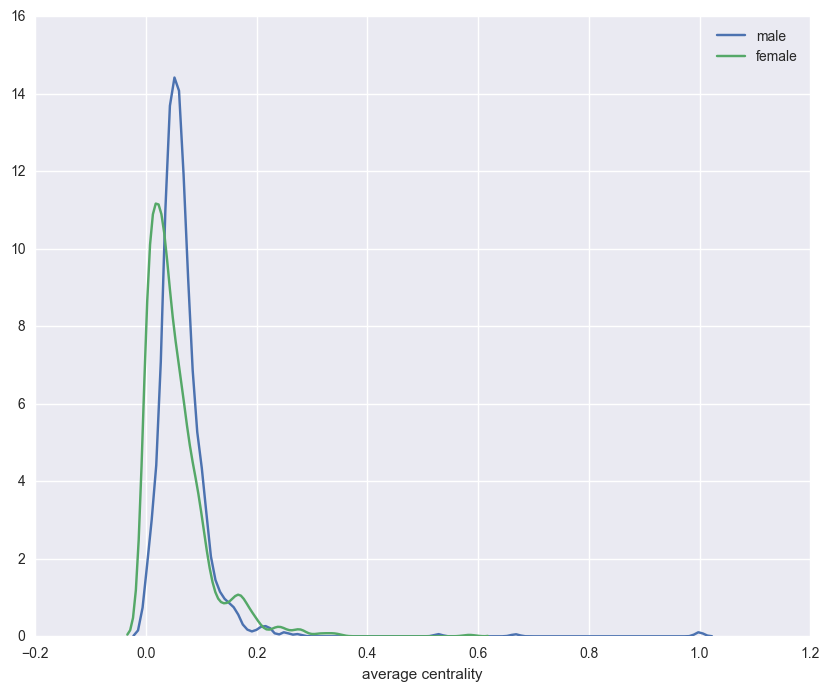

In [19]:
sns.distplot(male_cent, hist = False, label = "male");
sns.distplot(female_cent, hist = False, label = "female");
plt.legend();
plt.xlabel("average centrality");

In this case, there is a significant difference in the average centrality of male characters and female characters ($t(?) = 4.8805,\, p < 0.01$). In most of the scripts, males occupy a more central role than females.

In [42]:
sp.stats.ttest_ind(male_cent, female_cent, equal_var = False) #Welch’s t-test

Ttest_indResult(statistic=4.72219910990591, pvalue=2.5012086107725482e-06)

## By Genre

In [32]:
res = {}
for t in types:
    male_centr, female_centr = [], []
    for script, d in data.items():
        
        if t not in d['genres']:
            continue 
            
        G = d['graph']
        centralities = nx.betweenness_centrality(G)

        male_centr.append(np.mean([centralities[i] for i in G.nodes() if G.node[i]['gender'] == 'male']))
        female_centr.append(np.mean([centralities[i] for i in G.nodes() if G.node[i]['gender'] == 'female']))
    
    res[t] = {}
    res[t]['male'] = male_centr
    res[t]['female'] = female_centr

/Users/victor/miniconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/victor/miniconda3/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [33]:
# Pass into long format
tmp = []
for t, k in res.items():
    for g, v in k.items():
        for i in v:
            tmp.append((t, g, i))

tmp = pd.DataFrame(tmp, columns=["genre", "gender", "value"])

#Drop nan's
tmp = tmp[(tmp.genre!="Documentary")]
tmp = tmp[(tmp.genre!="Short")]
tmp = tmp[(tmp.genre!="Reality-TV")]

tmp.head()

,genre,gender,value
0,War,female,0.235951
1,War,female,0.015359
2,War,female,0.051965
3,War,female,NaN
4,War,female,0.040704


In [43]:
res = {}
for t in types:
    male_deg = tmp.ix[(tmp.genre == t) & (tmp.gender == "male"), "value"]
    female_deg = tmp.ix[(tmp.genre == t) & (tmp.gender == "female"), "value"]
    
    #Remove nans
    male_deg, female_deg = np.array(male_deg), np.array(female_deg)
    male_deg = male_deg[~np.isnan(male_deg)]
    female_deg = female_deg[~np.isnan(female_deg)]

    ttest = sp.stats.ttest_ind(male_deg, female_deg, equal_var = False) # Welch’s t-test

    if not np.isnan(ttest.pvalue):
        res[t] = ttest
    
res;

__ There is a real difference in the centrality of characters in: __

In [44]:
# Using Benjamin-Hochberg's method
res_2 = sorted(res.items(), key = lambda x: x[1].pvalue)
m = len(res_2)

i = 1
while i < len(res_2) + 1:
    if res_2[i - 1][1].pvalue > i / m * 0.05:
        break
    i = i + 1
        
res_2[:(i - 1)]

[('Drama',
  Ttest_indResult(statistic=5.5360939875294592, pvalue=3.8806730660466554e-08)),
 ('Comedy',
  Ttest_indResult(statistic=4.9053733356063445, pvalue=1.2265107217335973e-06)),
 ('Horror',
  Ttest_indResult(statistic=-4.453873832613291, pvalue=1.5560346287557535e-05)),
 ('Sport',
  Ttest_indResult(statistic=4.3270950950853493, pvalue=6.0490854332386626e-05)),
 ('Biography',
  Ttest_indResult(statistic=3.1811121245625564, pvalue=0.0019087391609333554)),
 ('Sci-Fi',
  Ttest_indResult(statistic=2.5263979961677898, pvalue=0.012115828338788286))]

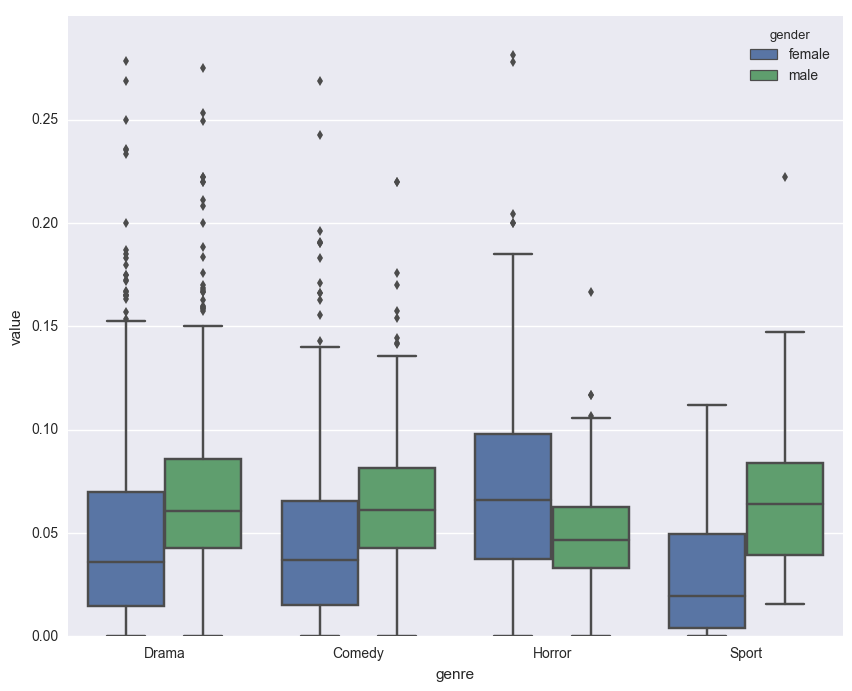

In [45]:
t = tmp[tmp.genre.isin(['Drama', 'Comedy', 'Horror', 'Sport'])]
bplt = sns.boxplot(x = 'genre', y = 'value', hue = 'gender', data = t)
bplt.axes.set_ylim([0, .3]);

In [38]:
for t in types:
    male_deg = tmp.ix[(tmp.genre == t) & (tmp.gender == "male"), "value"].mean()
    female_deg = tmp.ix[(tmp.genre == t) & (tmp.gender == "female"), "value"].mean()

    
    if male_deg < female_deg:
        print(t, male_deg, female_deg)
    

Western 0.0463948999487 0.0770071093583
Horror 0.0496216308536 0.0754689924878
Film-Noir 0.0754856560485 0.130046121844


## By Race

I can either agg by race (e.g., caucassian males get more important roles) or I could agg races by gender (e.g., latino women are more demanded than latino men).

In [21]:
# Agg by race

aggByRace = []

for script, d in data.items():
    G = d['graph']
    centrs = nx.betweenness_centrality(G)
    
    
    for n in G.nodes():
        aggByRace.append((G.node[n]['race'], centrs[n]))
        
aggByRace = pd.DataFrame(aggByRace, columns=['race', 'value'])
aggByRace = aggByRace[aggByRace.race != 'unknown']
aggByRace.head()

,race,value
1,latino,0.419872
2,caucasian,0.011752
4,caucasian,0.017094
6,caucasian,0.002137
7,caucasian,0.014957


### Fix: others -> other

In [22]:
aggByRace.ix[aggByRace.race == 'others','race'] = 'other'

In [23]:
def mean_confidence_interval(data, confidence = 0.9):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), stats.sem(a)
    h = se * stats.t._ppf((1 + confidence)/2., n - 1)
    return h

In [24]:
aggByRace.groupby("race").agg([len, 'mean', 'std', mean_confidence_interval])

value                                             
                    len      mean       std mean_confidence_interval
race                                                                
african           618.0  0.072249  0.116696                 0.007733
asianindian        59.0  0.080497  0.118180                 0.025718
caucasian        6038.0  0.080312  0.120143                 0.002544
eastasian          80.0  0.058346  0.100815                 0.018760
latino            196.0  0.069295  0.105030                 0.012399
nativeamerican     62.0  0.082293  0.137037                 0.029068
other             175.0  0.059663  0.077496                 0.009687
pacificislander    12.0  0.168502  0.164372                 0.085215

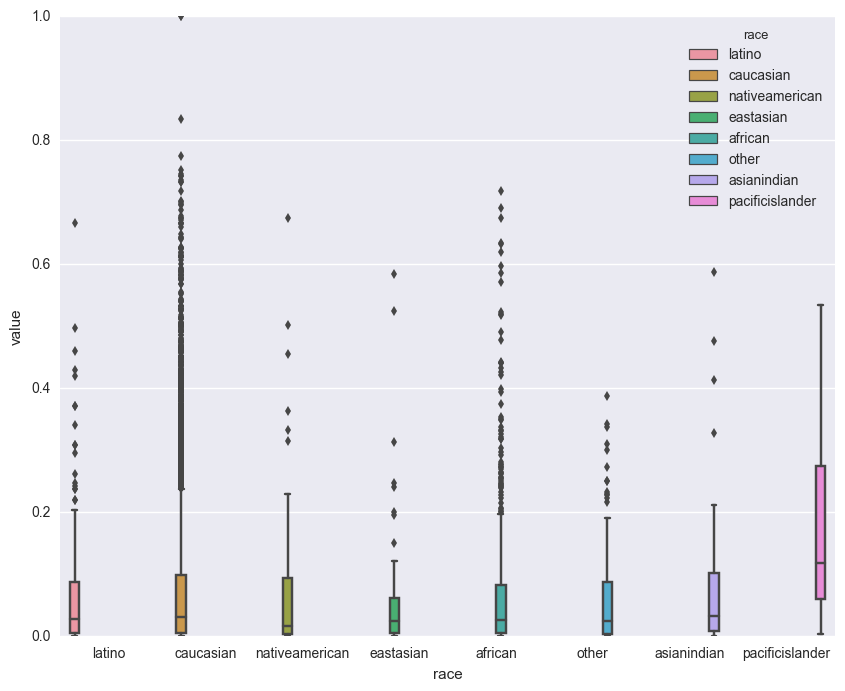

In [25]:
sns.boxplot(x = "race", y = "value", hue = "race", data = aggByRace);

In [26]:
#1-way ANOVA for differences

mod = ols('value ~ race',
                data=aggByRace).fit()
                
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)

              sum_sq      df         F    PR(>F)
race        0.253049     7.0  2.568264  0.012144
Residual  101.794627  7232.0       NaN       NaN


Post-hoc: Tukey HSD / Pairwise t-test w/ Holm correction

In [27]:
#print(pairwise_tukeyhsd(aggByRace['value'], aggByRace['race']));

In [49]:
from functools import partial
welch = partial(stats.ttest_ind, equal_var = False)
welch.__name__ = "Welch’s t-test"

mod = MultiComparison(aggByRace['value'], aggByRace['race'])
print(mod.allpairtest(welch, method = 'holm')[0]) #variance correction

Test Multiple Comparison Welch’s t-test 
FWER=0.05 method=holm
alphacSidak=0.00, alphacBonf=0.002
    group1          group2       stat   pval  pval_corr reject
--------------------------------------------------------------
   african       asianindian   -0.5127 0.6098    1.0    False 
   african        caucasian    -1.6313 0.1032    1.0    False 
   african        eastasian     1.1387 0.2573    1.0    False 
   african          latino      0.3338 0.7387    1.0    False 
   african      nativeamerican -0.5572 0.5792    1.0    False 
   african          other       1.6766 0.0944    1.0    False 
   african     pacificislander -2.0187 0.0681    1.0    False 
 asianindian      caucasian     0.012  0.9905    1.0    False 
 asianindian      eastasian     1.1614 0.2479    1.0    False 
 asianindian        latino      0.6544 0.5146    1.0    False 
 asianindian    nativeamerican -0.0773 0.9385    1.0    False 
 asianindian        other       1.2655 0.2096    1.0    False 
 asianindian   pacif

### By Age

In [55]:
# WHO THE FUCK HAD >!00 YRS!?
for script, d in data.items():
    G = d['graph']
    char_list = d['chars']
    
    for n in G.nodes():
        if G.node[n]['age'] > 100:
            print(script, char_list[n], G.node[n]['age'])

quantum_project.txt WILL 108


In [50]:
# Agg by age

aggByAge = []

for script, d in data.items():
    G = d['graph']
    centrs = nx.betweenness_centrality(G)
    
    
    for n in G.nodes():
        aggByAge.append((G.node[n]['age'], centrs[n]))
        
aggByAge = pd.DataFrame(aggByAge, columns=['age', 'value'])
aggByAge = aggByAge[aggByAge.age > 0]
aggByAge.head()

,age,value
1,36,0.419872
2,34,0.011752
4,50,0.017094
6,22,0.002137
7,42,0.014957


In [53]:
# Drop the guy with more than 100 yrs
aggByAge = aggByAge[aggByAge.age < 100]

In [57]:
stats.describe(aggByAge.age)

DescribeResult(nobs=8496, minmax=(2, 91), mean=39.503766478342747, variance=196.7966897554671, skewness=0.4591784524964515, kurtosis=0.08820386922768897)

In [54]:
# Make age groups
aggByAge['ageGrp'] = aggByAge.age.apply(lambda x: (x // 15) * 15)
aggByAge.groupby('ageGrp').agg([len, np.mean, np.std])

age                        value                    
         len       mean       std     len      mean       std
ageGrp                                                       
0        221  10.778281  2.761863   221.0  0.054439  0.096906
15      1886  24.462884  3.587549  1886.0  0.071423  0.110750
30      3613  36.710490  4.209070  3613.0  0.077046  0.123029
45      1972  50.870183  4.195548  1972.0  0.057330  0.103610
60       686  65.362974  4.098534   686.0  0.041682  0.067351
75       117  78.837607  3.311311   117.0  0.036881  0.090063
90         1  91.000000       NaN     1.0  0.002415       NaN

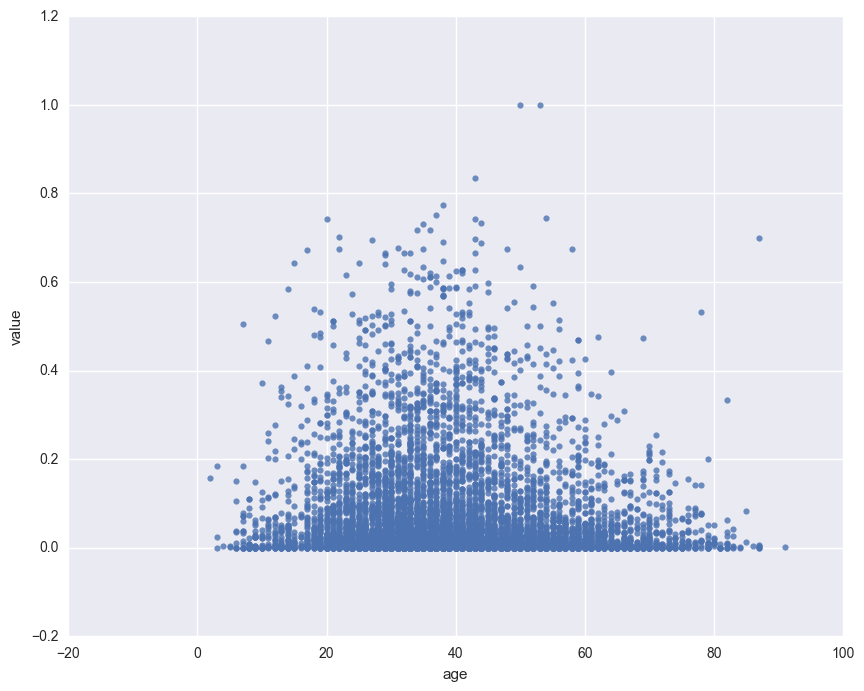

In [56]:
ax = sns.regplot(x = "age", y = "value", data = aggByAge, fit_reg = False)

### By Age and Gender

In [60]:
# Agg by age & gender

aggByAgeGender = []

for script, d in data.items():
    G = d['graph']
    centrs = nx.betweenness_centrality(G)
    
    
    for n in G.nodes():
        aggByAgeGender.append((G.node[n]['age'], G.node[n]['gender'], centrs[n]))
        
aggByAgeGender = pd.DataFrame(aggByAgeGender, columns=['age', 'gender', 'value'])
aggByAgeGender = aggByAgeGender[aggByAgeGender.age > 0]
aggByAgeGender = aggByAgeGender[aggByAgeGender.gender != 'unknown']

aggByAgeGender.head()

,age,gender,value
1,36,male,0.419872
2,34,male,0.011752
4,50,male,0.017094
6,22,female,0.002137
7,42,female,0.014957


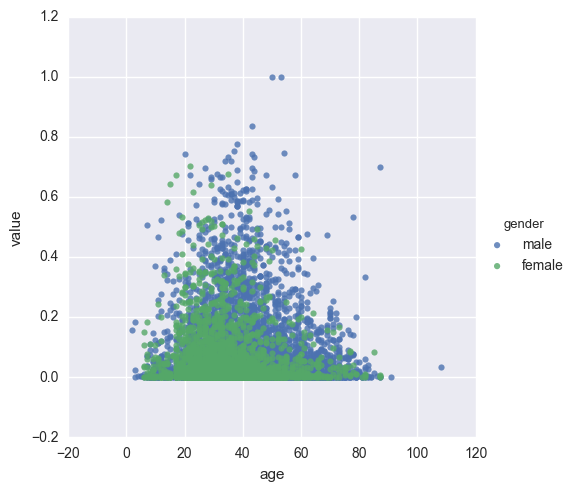

In [61]:
ax = sns.lmplot(x = "age", y = "value", hue = "gender", data = aggByAgeGender, fit_reg = False)

In [69]:
#sns.boxplot(x = "gender", y = "value", hue = "gender", data = aggByAgeGender);

In [83]:
ages_women = aggByAgeGender.ix[aggByAgeGender.gender == "female", "age"]
ages_male = aggByAgeGender.ix[aggByAgeGender.gender == "male", "age"]

#Remove nans
male_deg, female_deg = np.array(ages_male), np.array(ages_women)
male_deg = male_deg[~np.isnan(male_deg)]
female_deg = female_deg[~np.isnan(female_deg)]

ttest = sp.stats.ttest_ind(male_deg, female_deg, equal_var = False) #Welch’s t-test
ttest

Ttest_indResult(statistic=24.056687736313613, pvalue=8.0185505408523438e-121)

In [82]:
#2-way ANOVA for differences

mod = ols('value ~ C(gender) + age + C(gender):age',
                data=aggByAgeGender).fit()
                
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)

                   sum_sq      df          F        PR(>F)
C(gender)        0.389233     1.0  31.395524  2.170426e-08
age              0.778622     1.0  62.803590  2.572996e-15
C(gender):age    0.005967     1.0   0.481311  4.878482e-01
Residual       105.269138  8491.0        NaN           NaN


### Controlling by genre

In [85]:
res = {}
for t in types:
    male_age, female_age = [], []
    for script, d in data.items():
        
        if t not in d['genres']:
            continue 
            
        G = d['graph']
        #centralities = nx.betweenness_centrality(G)

        male_age.extend([G.node[i]['age'] for i in G.nodes() if G.node[i]['gender'] == 'male'])
        female_age.extend([G.node[i]['age'] for i in G.nodes() if G.node[i]['gender'] == 'female'])
    
    res[t] = {}
    res[t]['male'] = male_age
    res[t]['female'] = female_age

In [87]:
# Pass into long format
tmp = []
for t, k in res.items():
    for g, v in k.items():
        for i in v:
            tmp.append((t, g, i))

tmp = pd.DataFrame(tmp, columns=["genre", "gender", "age"])

#Drop nan's
tmp = tmp[(tmp.genre!="Documentary")]
tmp = tmp[(tmp.genre!="Short")]
tmp = tmp[(tmp.genre!="Reality-TV")]

# Drop zero age
tmp = tmp[tmp.age > 0]

tmp.head()

,genre,gender,age
0,War,female,32
1,War,female,36
2,War,female,28
9,War,female,48
10,War,female,66


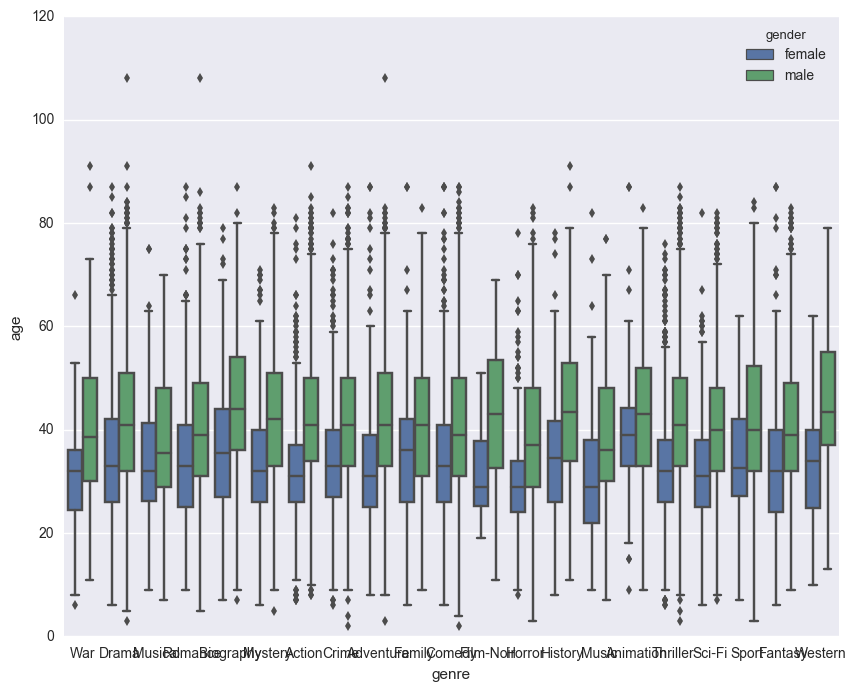

In [88]:
sns.boxplot(x = "genre", y = "age", hue = "gender", data = tmp);

In [100]:
res = {}
for t in types:
    male_deg = tmp.ix[(tmp.genre == t) & (tmp.gender == "male"), "age"]
    female_deg = tmp.ix[(tmp.genre == t) & (tmp.gender == "female"), "age"]
    
    #Remove nans
    male_deg, female_deg = np.array(male_deg), np.array(female_deg)
    male_deg = male_deg[~np.isnan(male_deg)]
    female_deg = female_deg[~np.isnan(female_deg)]

    ttest = sp.stats.ttest_ind(male_deg, female_deg, equal_var = False) # Welch’s t-test

    if not np.isnan(ttest.pvalue):
        res[t] = ttest
    
res;

In [101]:
# Using Benjamin-Hochberg's method
res_2 = sorted(res.items(), key = lambda x: x[1].pvalue)
m = len(res_2)

i = 1
while i < len(res_2) + 1:
    if res_2[i - 1][1].pvalue > i / m * 0.05:
        break
    i = i + 1
        
res_2[:(i - 1)]

[('Thriller',
  Ttest_indResult(statistic=17.275424930624947, pvalue=5.186587241914562e-61)),
 ('Action',
  Ttest_indResult(statistic=17.25697414592408, pvalue=4.1303368013383058e-58)),
 ('Drama',
  Ttest_indResult(statistic=16.289116842666555, pvalue=4.1979057154387908e-57)),
 ('Crime',
  Ttest_indResult(statistic=12.927023062146688, pvalue=3.6641073267575731e-35)),
 ('Comedy',
  Ttest_indResult(statistic=11.485135304358279, pvalue=1.7870471098666947e-29)),
 ('Adventure',
  Ttest_indResult(statistic=11.84244389128513, pvalue=2.3980373049252168e-29)),
 ('Sci-Fi',
  Ttest_indResult(statistic=11.775471274955615, pvalue=2.7995396820758888e-29)),
 ('Mystery',
  Ttest_indResult(statistic=11.334262079122082, pvalue=2.304317262818154e-27)),
 ('Romance',
  Ttest_indResult(statistic=9.4208848089303139, pvalue=1.828204576761656e-20)),
 ('Horror',
  Ttest_indResult(statistic=9.3984266402122536, pvalue=6.755507355819917e-20)),
 ('Fantasy',
  Ttest_indResult(statistic=8.7193097258915735, pvalue=2.7

In [99]:
set(types) - set(map(lambda x: x[0], res_2))

{'Short'}